# Example Classification

In this notebook will be showed how to use lit-saint for a classification problem. We will use the "Census Income" dataset in which the objective is to predict whether income exceeds $50K/yr based on census data

## Import libraries <a class="anchor" id="import"></a>

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import wget
from lit_saint import Saint, SaintConfig, SaintDatamodule, SaintTrainer
from pytorch_lightning import Trainer, seed_everything

## Download Data <a class="anchor" id="download"></a>

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
out = Path(os.getcwd() + '/data/adult.csv')
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    wget.download(url, out.as_posix())

File already exists.


## Configure lit-saint <a class="anchor" id="configure"></a>

In [3]:
# if you want to used default value for the parameters
cfg = SaintConfig()

# otherwise you can use hydra to read a config file (uncomment the following part)
# from hydra.core.config_store import ConfigStore
# cs = ConfigStore.instance()
# cs.store(name="base_config", node=SaintConfig)
# with initialize(config_path="."):
#   cfg = compose(config_name="config")


## Prepare Data <a class="anchor" id="prepare"></a>

In [4]:
seed_everything(42, workers=True)
df = pd.read_csv(os.getcwd() + "/data/adult.csv", header=None)
df_train, df_test = train_test_split(df, test_size=0.10, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.10, random_state=42)
df_train["split"] = "train"
df_val["split"] = "validation"
df = pd.concat([df_train, df_val])
# The target is in the column number 14 and we can see that it contains some string so the library will considered the problem as a classification
df.head()

Global seed set to 42


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,split
25402,19,State-gov,67217,Some-college,10,Never-married,Other-service,Not-in-family,White,Male,594,0,24,United-States,<=50K,train
5221,18,Private,300379,12th,8,Never-married,Adm-clerical,Own-child,White,Male,0,0,12,United-States,<=50K,train
11528,18,Private,150817,HS-grad,9,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K,train
11085,28,?,80165,Some-college,10,Divorced,?,Not-in-family,White,Female,0,0,30,United-States,<=50K,train
11464,69,Private,108196,9th,5,Never-married,Craft-repair,Other-relative,White,Male,2993,0,40,United-States,<=50K,train


## Fit the model <a class="anchor" id="fit"></a>

In [ ]:
data_module = SaintDatamodule(df=df, target=df.columns[14], split_column="split",
                              num_workers=cfg.network.num_workers,
                              data_loader_params={"batch_size": cfg.network.batch_size})
model = Saint(categories=data_module.categorical_dims, continuous=data_module.numerical_columns,
              config=cfg, dim_target=data_module.dim_target)
pretrainer = Trainer(max_epochs=cfg.pretrain.epochs)
trainer = Trainer(max_epochs=cfg.train.epochs)
saint_trainer = SaintTrainer(pretrainer=pretrainer, trainer=trainer)
saint_trainer.fit(model=model, datamodule=data_module, enable_pretraining=True)

## Make predictions <a class="anchor" id="predict"></a>

In [ ]:
prediction = saint_trainer.predict(model=model, datamodule=data_module, df=df_test)
df_test["prediction"] = np.argmax(prediction, axis=1)

In [7]:
print(classification_report(data_module.predict_set[df.columns[14]], df_test["prediction"]))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2456
           1       0.78      0.63      0.70       801

    accuracy                           0.87      3257
   macro avg       0.83      0.79      0.80      3257
weighted avg       0.86      0.87      0.86      3257



## Uncertainty Estimation <a class="anchor" id="uncertainty"></a>

In [ ]:
mc_prediction = saint_trainer.predict(model=model, datamodule=data_module, df=df_test, mc_dropout_iterations=4)

In [9]:
mc_prediction

array([[[0.9885666 , 0.98791903, 0.987258  , 0.986961  ],
        [0.01143348, 0.01208097, 0.01274193, 0.01303895]],

       [[0.4831934 , 0.46905848, 0.4488404 , 0.5043215 ],
        [0.51680666, 0.53094155, 0.55115956, 0.49567848]],

       [[0.38506672, 0.42264497, 0.37724075, 0.39455432],
        [0.61493325, 0.577355  , 0.6227592 , 0.6054457 ]],

       ...,

       [[0.58161247, 0.5454856 , 0.56008404, 0.5523559 ],
        [0.41838756, 0.4545144 , 0.43991593, 0.44764405]],

       [[0.9095162 , 0.91370744, 0.9123672 , 0.8962503 ],
        [0.09048383, 0.08629262, 0.08763281, 0.10374971]],

       [[0.42250738, 0.41206264, 0.42539898, 0.40183735],
        [0.5774926 , 0.5879373 , 0.574601  , 0.59816265]]], dtype=float32)

array([[<AxesSubplot:title={'center':'variance'}>]], dtype=object)

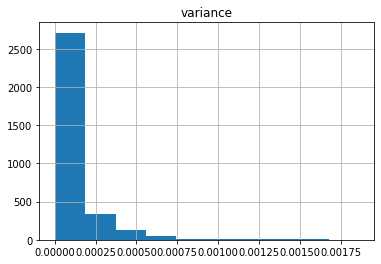

In [10]:
# Given the predictions we can compute the variance across the iterations, so axis=2
var_prediction = np.var(mc_prediction,axis=2)
# Then we focus our attention on the variance of the first class
pd.DataFrame(var_prediction[:,0], columns=["variance"]).hist()